# This notebook contains all the code for clustering algorithms and the plots created for the thesis
## Depending on the details of the device you are running the code on, some algorithms might take a long time to run due to the large amount of data
### Importing all the necessary libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from tslearn.metrics import dtw
from tslearn.metrics import gak, sigma_gak
from tslearn.clustering import TimeSeriesKMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences

# Reading, Creating the datasets
### 1. Type 1 : Data from PCA analysis with the first five components
### 2. Type 2 : Raw data

#### <span style="color:red">change the directory of the file relative to where you have saved it after unpacking the project</span>.

In [4]:
##########################################
### 1. Type 1 : Data from PCA analysis with the first five components
Type1 = pd.read_excel('VIPCA.xlsx')
Type1 = Type1.rename(columns={"index": "PatientID"})
Type1 = Type1.set_index('PatientID')
##########################################

##########################################
### 1. Type 2 : Raw data
Rawdata = pd.read_csv('Thesis-data/merged.csv')
Rawdata = Rawdata.drop(["Unnamed: 0",'Gender','WardID','Conciousness','Timestamp'], axis = 1)
### scaling the raw data for training
Type2 = StandardScaler().fit_transform(Rawdata)
Type2 = pd.DataFrame(Type2,index=Rawdata.index, columns=Rawdata.columns)
Type2['PatientID'] = Rawdata['PatientID']
##########################################

### 2. Type 3 : Interpolation data
#### <span style="color:red">The code for generating the interpolation dataset has been provided by the superviser Helge Fredriksen</span>.

In [18]:
from datetime import timedelta, time

import numpy as np
import pandas
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from enum import Enum
from sklearn.preprocessing import StandardScaler

OneDayInMillis = 24 * 60 * 60 * 1000


class Sample:
    def __init__(self, row: pandas.Series):
        self._timestamp = row['Timestamp']
        self._normalized_time = 0
        self._systolic = row['Systolic']
        self._diastolic = row['Diastolic']
        self._o2 = row['O2']
        self._pulse = row['Pulse']
        self._temp = row['Temp']
        self._rf = row['Rf']
        self._gender = row['Gender']
        self._consciousness = row['Conciousness']

    @property
    def timestamp(self):
        return self._timestamp

    @property
    def systolic(self):
        return self._systolic

    @property
    def diastolic(self):
        return self._diastolic

    @property
    def o2(self):
        return self._o2

    @property
    def pulse(self):
        return self._pulse

    @property
    def temp(self):
        return self._temp

    @property
    def rf(self):
        return self._rf

    @property
    def gender(self):
        return self._gender

    @property
    def consciousness(self):
        return self._consciousness

    @property
    def normalized_time(self):
        return self._normalized_time


class Timeseries:

    def __init__(self, data: pandas.DataFrame, impute_value, num_interpol_points, pas_id, longest_time):
        self._impute_value = impute_value
        self._syst = None
        self._dia = None
        self._o2 = None
        self._pulse = None
        self._temp = None
        self._rf = None
        self._truncated = False
        try:
            self._ward = data['WardID'].iloc[0]
        except Exception:
            self._ward = 0
        self._patient_id = pas_id
        self._interpol_points = num_interpol_points
        self._samples = []
        self._interpolates = []
        self._error_during_interpolation = False
        previousSample = None
        skip_data_after_this = data['Timestamp'].iloc[0] + longest_time
        for index, row in data.iterrows():
            if row['Timestamp'] > skip_data_after_this:
                self._truncated = True
                break
            sample = Sample(row)
            if previousSample is not None and sample.timestamp == previousSample.timestamp:  # Filter out samples with same timestamp.
                continue
            self._samples.append(sample)
            previousSample = sample

    def length(self):
        return len(self._samples)

    def get_interpolated(self):
        T = np.zeros((self._interpol_points, 6))
        if self._syst is None:  # Means that there was an error during interpolation.
            print("Got a problem for patient ID", self._patient_id)
            return None

        for i in range(self._interpol_points):
            T[i, :] = np.array([self._syst[i], self._dia[i], self._o2[i], self._pulse[i], self._temp[i], self._rf[i]])

        # if np.isnan(T).any():
        #     print("Got a NaN for patient ID", self._patient_id)
        return T

    def interpolate(self, timespan):
        # We need to start in t=0

        t_start = self._samples[0].timestamp

        for sample in self._samples:
            sample._normalized_time = (sample.timestamp - t_start) / timespan

        timestamps, syst, dia, o2, pulse, temp, rf, gender, con = self._get_raw_no_interpolate()
        i = 0
        for sample in self._samples:
            timestamps[i] = sample._normalized_time
            i += 1

        last_timestamp = timestamps[-1]
        # Creates only as many interpolation points as there is time for in the interval [0, last_timestamp].
        # The total number of points will be interpol_points, but this array should have points only reaching
        # up to last_timestamp, but equally spaced as all other time-series. Step size is 1/interpol_points.
        # The rest of the remaining interpolation points must be imputed with self._impute_value
        tau = np.arange(start=0, stop=last_timestamp, step=1 / self._interpol_points)
        points_filled = len(tau)
        left_overs = self._interpol_points - points_filled

        # kindString = 'quadratic'
        # kindString = 'cubic'
        kindString = 'slinear'

        try:
            Q = interp1d(timestamps, syst, kind=kindString)
            self._syst = Q(tau)
            # plt.plot(timestamps,syst)
            # plt.plot(tau, self._syst)
            # plt.show()
            self._syst = np.append(self._syst, np.ones(
                left_overs) * self._impute_value)  # Add the impute value on leftovers in the timeseries.

            Q = interp1d(timestamps, dia, kind=kindString)
            self._dia = Q(tau)
            self._dia = np.append(self._dia, np.ones(left_overs) * self._impute_value)

            Q = interp1d(timestamps, o2, kind=kindString)
            self._o2 = Q(tau)
            self._o2 = np.append(self._o2, np.ones(left_overs) * self._impute_value)

            Q = interp1d(timestamps, pulse, kind=kindString)
            self._pulse = Q(tau)
            self._pulse = np.append(self._pulse, np.ones(left_overs) * self._impute_value)

            Q = interp1d(timestamps, temp, kind=kindString)
            self._temp = Q(tau)
            self._temp = np.append(self._temp, np.ones(left_overs) * self._impute_value)

            Q = interp1d(timestamps, rf, kind=kindString)
            self._rf = Q(tau)
            self._rf = np.append(self._rf, np.ones(left_overs) * self._impute_value)
        except ValueError as err:
            self._error_during_interpolation = True
            print("Interpolation error:", err, "for patientID", self._patient_id)

    def failed_during_interpolation(self):
        return self._error_during_interpolation

    def get_length(self):
        return len(self._samples)

    def dump(self, writer, index):
        timestamps, syst, dia, o2, pulse, temp, rf, gender, con = self._get_raw_no_interpolate()
        for i in range(len(timestamps)):
            to_write = '{},{},{},{},{},{},{},{},{},{},{},{}\n'.format(index, self._patient_id,
                                                                      self._ward,
                                                                      timestamps[i],
                                                                      syst[i],
                                                                      dia[i],
                                                                      o2[i],
                                                                      pulse[i],
                                                                      temp[i],
                                                                      rf[i],
                                                                      gender[i],
                                                                      con[i])
            writer.write(to_write)
            index += 1

        return index

    def _get_raw_no_interpolate(self):
        syst = []
        dia = []
        o2 = []
        pulse = []
        temp = []
        rf = []
        gender = []
        con = []
        timestamps = []
        t_0 = self._samples[0].timestamp
        for i in range(len(self._samples)):
            sample = self._samples[i]
            syst.append(sample.systolic)
            dia.append(sample.diastolic)
            o2.append(sample.o2)
            pulse.append(sample.pulse)
            temp.append(sample.temp)
            rf.append(sample.rf)
            gender.append(sample.gender)
            con.append(sample.consciousness)
            timestamps.append(sample.timestamp)

        return timestamps, syst, dia, o2, pulse, temp, rf, gender, con

    @property
    def syst(self):
        return self._syst

    @property
    def dia(self):
        return self._dia

    @property
    def o2(self):
        return self._o2

    @property
    def pulse(self):
        return self._pulse

    @property
    def temp(self):
        return self._temp

    @property
    def rf(self):
        return self._rf

    @property
    def ward(self):
        return self._ward

    @ward.setter
    def ward(self, value):
        self._ward = value

    @property
    def truncated(self):
        return self._truncated


class ActionLongPauses(Enum):
    NoAction = 1
    Split = 2
    Truncate = 3


# Explanation on functionality of splitting/truncating time-series with too long pauses in registered samples:
#
# Some time-series have "pauses", meaning that the patient were either moved to another place in the hospital for
#    some time, or admitted back to the hospital after being discharged for a period. If such a pause is detected,
#    based on pauses longer than the parameter "longest_pause", there are three different action that can be taken
#    a) action_on_pause = ActionLongPauses.Split: Split the time-series into new ones, generating new patientID to
#       separate it from the old
#    b) action_on_pause = ActionLongPauses.Truncate: Do not use samples after pause. This is the recommended action
#       from NLSH
#    c) action_on_pause = ActionLongPauses.NoAction: Keep the series the way it is.

# Some notes on length filtering:
#    a) shortest_num_samples_allowed: There is not much information in two samples, and even three samples are a bit
#       short to make anything useful out of it in terms of extracting topology
#    b) longest_time_for_series:
#       For interpolation purposes we cannot have too long time series due to the problem that shorter ones would loose
#       significance (all series should be in the same interval after being interpolated).
#       T_longest is used as a normalizing factor, that is tau = (t - t_min)/T_longest will be the new "normalized" time
#       spanning from [0,1] for all series.
#       If encountering series longer than this time, it will be truncated at the timestamp before.

class Controller:
    def __init__(self,
                 interpol_points=45,  # Number of equally spaced interpolation points ("normalized" timestamps in [0,1])
                 longest_pause=OneDayInMillis,  # If encountering pauses in registrations longer than this, take action
                 truncate_initial=0,  # Number of days with non-real data at the start that can be skipped
                 shortest_num_samples_allowed=3,  # Do not consider timeseries with less data-points.
                 longest_time_for_series=100,  # We are only looking on max this number of days during a stay.
                 action_on_pauses=ActionLongPauses.NoAction,  # How to handle pauses (see explanation above)
                 normalize=False,  # When outputting interpolated data, should they be normalized first?
                 replace_ward=False  # The wardID is replaced with an enumeration symbolizing type of ward
                 ):
        self._max_id = 0
        self._replaceWard = replace_ward
        self._shortest_num_samples_allowed = shortest_num_samples_allowed  # How
        self._longest_time_for_series = longest_time_for_series * OneDayInMillis
        self._num_interpol_points = interpol_points
        self._longest_pause = longest_pause
        self._truncate_initial = truncate_initial * OneDayInMillis  # Do the first records symbolize bogus data?
        self._series = []
        self._longest_timespan = 0
        self._skipped_short = 0
        self._truncated = 0
        self._action_on_pauses = action_on_pauses
        self._normalize_features = normalize
        self.__contains_ward = False

    def __normalize(self, df):
        x = df['Systolic'].to_numpy()
        df['Systolic'] = pd.Series(StandardScaler().fit_transform(x[:, np.newaxis]).flatten())
        x = df['Diastolic'].to_numpy()
        df['Diastolic'] = pd.Series(StandardScaler().fit_transform(x[:, np.newaxis]).flatten())
        x = df['O2'].to_numpy()
        df['O2'] = pd.Series(StandardScaler().fit_transform(x[:, np.newaxis]).flatten())
        x = df['Pulse'].to_numpy()
        df['Pulse'] = pd.Series(StandardScaler().fit_transform(x[:, np.newaxis]).flatten())
        x = df['Temp'].to_numpy()
        df['Temp'] = pd.Series(StandardScaler().fit_transform(x[:, np.newaxis]).flatten())
        x = df['Rf'].to_numpy()
        df['Rf'] = pd.Series(StandardScaler().fit_transform(x[:, np.newaxis]).flatten())
        return df

    # Return values after filtering:
    # 1) Initial number of time-series
    # 2) Number of series skipped caused by too few samples (controlled by the parameter _shortest_num_samples_allowed)
    # 3) Length of the longest time series found in the data material
    # 4) Number of timeseries truncated either due to too length in milliseconds (controlled by _longest_time_for_series)
    #    or detected pause in series if _action_on_pauses is set to ActionLongPauses.Truncate
    def load_csv(self, filename="data/EWS.csv"):
        df = pd.read_csv(filename)
        global_first = df['Timestamp'].min()
        self.__contains_ward = 'WardID' in df.columns

        df = df[df['Timestamp'] >= global_first + self._truncate_initial]
        # df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms', origin='unix')

        # Just to make sure that data following one patient is ordered successively
        patients = df['PatientID'].unique()

        if self._normalize_features:
            df = self.__normalize(df)

        self._max_id = max(patients)
        for patient_id in patients:
            data = df.loc[df['PatientID'] == patient_id]
            data = data.sort_values(by="Timestamp")
            self.__create_timeseries(data, False)
        # PS: Returning len(patients) aren't really true as a measure of how many time-series we are considering prior
        # to the filtering. This is due to the fact that we may split time-series due to long pauses. However, it is not
        # that important at this stage to support a proper reporting of this.
        return len(patients), self._skipped_short, timedelta(milliseconds=float(self._longest_timespan)), \
            self._truncated

    def dump(self, filename):
        writer = open(filename, 'w', encoding="utf-8")
        writer.write("Index,PatientID,WardID,Timestamp,Systolic,Diastolic,O2,Pulse,Temp,Rf,Gender,Conciousness\n")
        index = 0
        for series in self._series:
            index = series.dump(writer, index)
        writer.close()

    # Support for splitting timeseries into several, and additionally assigning new unique pasientIDs to those arising
    # from the split process. This is performed recursively.
    def __create_timeseries(self, data: pandas.DataFrame, generate_id: bool):
       # print(data.shape)
        #print(data)
        if data.shape[0] < self._shortest_num_samples_allowed:
            self._skipped_short += 1
            return

        t_first = data['Timestamp'].iloc[0]
        t_split = t_first + self._longest_pause
        t_last = data['Timestamp'].iloc[-1]
        timespan = t_last - t_first

        # If no truncation or splitting required, just check if it's not too long, and if not just create and add it
        pas_id = data['PatientID'].iloc[0]
        if self._action_on_pauses == ActionLongPauses.NoAction:
            self.__add_if_valid(data, pas_id, timespan)
            return

        if generate_id:
            self._max_id += 1
            pas_id = self._max_id

        if t_last < t_split:  # Stop condition, the last timestamp is before the split candidate time
            self.__add_if_valid(data, pas_id, timespan)
            return

        # We need to check for long pauses inside time-series
        t_0 = t_first
        index = 0
        for _, row, in data.iterrows():
            t_1 = row['Timestamp']
            if t_1 - t_0 > self._longest_pause:
               # print("some not recursive shit")
                # Ok, found the pause. Now try to perform the splitting into two new dataframes.
                first = data.iloc[:index]
                # If we just truncate, no need to do a recursive splitting, just make the timeseries based on the last part
                if self._action_on_pauses == ActionLongPauses.Truncate:
                #    print("not recursive shit")
                    self.__add_if_valid(first, pas_id, timespan)
                    self._truncated += 1
                else:
                 #   print("recursive shit")
                    last = data.iloc[index:]
                    self.__create_timeseries(first, False)
                    self.__create_timeseries(last, True)
                return
            else:
                t_0 = t_1
            index += 1

        # Ok, so time-series was longer than self._longest_pause, but no pauses were found
        self.__add_if_valid(data, pas_id, timespan)
        return

    def __add_if_valid(self, data, pas_id, timespan):
        time_series = Timeseries(data, 0, self._num_interpol_points, pas_id, self._longest_time_for_series)
        if self._replaceWard:
            time_series.ward = self.getWard(time_series.ward)
        if self.__length_check(time_series, timespan):
            if time_series.truncated:
                self._truncated += 1
            self._series.append(time_series)

    def __length_check(self, time_series, timespan):

        if time_series.length() < self._shortest_num_samples_allowed:
            self._skipped_short += 1
            return False

        if timespan > self._longest_timespan:
            self._longest_timespan = timespan  # Store this timespan for later normalization

        return True

    def interpolate(self):

        for timeseries in self._series:
            timeseries.interpolate(self._longest_time_for_series)  # Correction: No point in using longest timespan of series, just use the setting...

        # The following is a memory allocation "hack" due to the remove() in the iteration above leading to
        # very strange effects on neighbouring elements in the list...

        temp = []
        for timeseries in self._series:
            if timeseries.failed_during_interpolation():
                continue
            else:
                temp.append(timeseries)
        self._series = temp

    def get_series_3D_numpy(self):
        X = np.zeros((len(self._series), self._num_interpol_points, 6))
        for i in range(len(self._series)):
            X[i, :, :] = self._series[i].get_interpolated()
        return X

    def get_ward_labels(self):
        Y = np.zeros((len(self._series), 1))
        if self.__contains_ward:
            for i in range(len(self._series)):
                w = self._series[i]._ward
                Y[i] = self.getWard(w)

        return Y

    # Mapping based on info from Ståle Nymo:  (NB: TOOK INTO CONSIDERATION ADDED INFO FROM MAIL
    # 1: Psychiatry: 106, 105, 107, 70, 72
    # 2: Medicine: 84, 83, 110, 64, 65, 85
    # 3: Surgical AND Ortopedics (75): 67, 91, 114, 92, 75
    # 5: Neurology: 79
    # 6: ICU: 96, 82
    # 7: Obst / Gyn: 97, 117
    # 8: Observation unit: 108
    # 9: Unknown

    def getWard(self, w):
        if w == 106 or w == 105 or w == 107 or w == 72 or w == 70:
            return 1
        elif w == 83 or w == 84 or w == 85 or w == 64 or w == 65 or w == 110:
            return 2
        elif w == 67 or w == 91 or w == 92 or w == 114 or w == 75:
            return 3
        elif w == 79:
            return 5
        elif w == 96 or w == 82:
            return 6
        elif w == 97 or w == 117:
            return 7
        elif w == 108:
            return 8
        else:
            return 9


def main():
    # First file (EWS.csv) is processed this way:
    # 1) 60 days of junk data in the beginning of the file, need to truncate that
    # 2) Split the time-series in pauses for maximum training data
    # 3) Series longer than 2 days should not be utilized to avoid the issue mentioned above when interpolating

    #    If NOT used for interpolation, we don't need to care about this.
    controller = Controller(action_on_pauses=ActionLongPauses.Truncate,
                             longest_time_for_series=2,normalize=True)
    num_series, skipped_short, longest, truncated = controller.load_csv(filename="Thesis-data/merged.csv")
    #controller.dump("Thesis-data/EWS_processed.csv")

    #controller = Controller(action_on_pauses=ActionLongPauses.Truncate, longest_time_for_series=2, replace_ward=False)
    #num_series, skipped_short, longest, truncated = controller.load_csv(filename="Thesis-data/month02_ward_classified.csv")
    
    
    print("Finished loading, total number of series loaded was", num_series, ". We skipped", skipped_short,
        "of these due to too few samples. Number of truncated series was", truncated,"longest is ",longest)
    #controller.dump("Thesis-data/month02_.csv")

    controller.interpolate()
    X = controller.get_series_3D_numpy()
    print('Loaded NLSH data, shape: '+ str(X.shape))
    Y = controller.get_ward_labels()
    #print(X)
    #controller.dump("data/month02_ward_classified.csv")
    return (X,Y)


if __name__ == "__main__":
    X,Y = main()

Finished loading, total number of series loaded was 5619 . We skipped 0 of these due to too few samples. Number of truncated series was 0 longest is  1 day, 23:59:54.518000
Loaded NLSH data, shape: (5619, 45, 6)


# Necessary Functions

In [9]:
###################################################
# The raw data set needs to be turned into a sequence to be able to use it for training so that every patient has it's
# registeration separately
###################################################
def createSequence(df):
    grouped = df.groupby("PatientID")
    PatientIDs = df['PatientID'].unique()

    AllPatient = []
    for ID in PatientIDs:
        PatientArr = []
        group = grouped.get_group(ID) 
        i = len(group.index)
        for index in range(0,i):
            Arr = []
            Arr.append(group.iloc[index]['Systolic'])
            Arr.append(group.iloc[index]['Diastolic'])
            Arr.append(group.iloc[index]['O2'])
            Arr.append(group.iloc[index]['Pulse'])
            Arr.append(group.iloc[index]['Temp'])
            Arr.append(group.iloc[index]['Rf'])
            Arr = np.array(Arr)
            PatientArr.append(Arr)
        index = 0
        PatientArr = np.array(PatientArr)
        AllPatient.append(PatientArr)
    AllPatient =np.array(AllPatient, dtype=object)
    return AllPatient
###################################################

###################################################
# DBI function is for measuring the Davies-Bouldin score
###################################################
def DBI(data,label):
    dbi_score = davies_bouldin_score(data, label)
    print("The Davies-Bouldin score for this model is : ", dbi_score)
###################################################


###################################################
# Finding the suitable number of clusters for each method
###################################################
def NumOfCLuster(model,data):
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2,20),metric='silhouette', timings= True)
    visualizer.fit(data)# Fit the data to the visualizer
    visualizer.show() 
###################################################
def DTWDistance(AllPatient):
    n_samples = len(AllPatient)
    similarity_matrix = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            distance = dtw(AllPatient[i], AllPatient[j])
            similarity_matrix[i, j] = distance
            similarity_matrix[j, i] = distance
    return similarity_matrix
###################################################
def CalculateGAK(AllPatient):
    n_samples = len(AllPatient)
    sigma = sigma_gak(AllPatient)
    similarity_matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            distance = gak(AllPatient[i], AllPatient[j], sigma=sigma)
            similarity_matrix[i, j] = distance
            similarity_matrix[j, i] = distance
    return similarity_matrix

###################################################
def calculateSimilairityNorm(matrix):
    # assume similarity_matrix is the original matrix
    # find the minimum and maximum values
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    # apply min-max scaling to rescale values to [0, 1]
    similarity_matrix_norm = (matrix - min_val) / (max_val - min_val)
    return similarity_matrix_norm
###################################################
def calculateDissimilarity(matrix):
# Compute Dissimilarity matrix
    dissimilarity = 1 - matrix
    np.fill_diagonal(dissimilarity, 0)
    return dissimilarity

###################################################
def ScipyHierarchy(matrix,t):
    distArray = ssd.squareform(matrix)
    Z = linkage(distArray, 'ward')
    clust = fcluster(Z, t, criterion="distance")
    print("Found %d clusters"%len(np.unique(clust)))
    print(len(clust))
    fig = plt.figure(figsize=(20, 10))
    dn = dendrogram(Z, color_threshold=t, labels=None, above_threshold_color='k')
    plt.show()
    return clust

# Kmeans
## 1. Euclidean Kmeans with Type 1 dataset

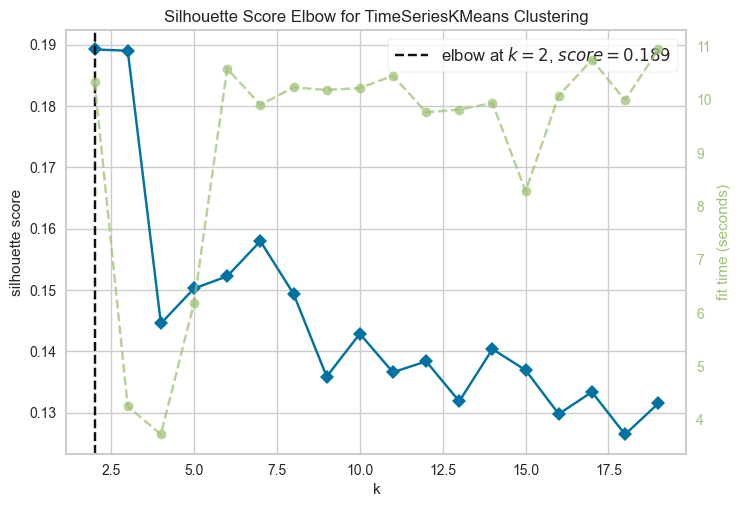

The Davies-Bouldin score for this model is :  1.912095121101879


In [11]:
# Finding the suitable number of clusters for the method
model =TimeSeriesKMeans()
NumOfCLuster(model,Type1)
# Training the model based on the number of clusters received from silhouette score and Type 1 dataset
label = TimeSeriesKMeans(n_clusters=2, random_state=0).fit_predict(Type1)
DBI(Type1,label)

## 2. Dynamic Time Warping Kmeans with Type 3 dataset

In [ ]:
# Finding the suitable number of clusters for the method
sampled_data = X[np.random.choice(X.shape[0], 500, replace=False)]
sampled_data= sampled_data.reshape(sampled_data.shape[0],sampled_data.shape[1]*sampled_data.shape[2])
model = TimeSeriesKMeans(metric="dtw",random_state=0,max_iter=30,max_iter_barycenter=20)
NumOfCLuster(model,sampled_data)
# Training the model based on the number of clusters received from silhouette score and Type 3 dataset
Xlabeldtw = TimeSeriesKMeans(n_clusters=2, metric="dtw",random_state=0,max_iter=30,max_iter_barycenter=20).fit_predict(X)
X_flat = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
DBI(X_flat,Xlabeldtw)

## 3. Soft Dynamic Time Warping Kmeans with Type 3 dataset

In [ ]:
Xlabelsoft = TimeSeriesKMeans(n_clusters=2, metric="softdtw",metric_params={"gamma": .1},random_state=0,max_iter=30,max_iter_barycenter=30).fit_predict(X)
DBI(X_flat,Xlabelsoft)

# Hierarchical clustering
## 1. Hierarchical clustering with Type 2 dataset (raw data)

In [ ]:
# Creating a sequence where each patient has it's own registeration as a group of arrays
AllPatient = createSequence(Type2)
# padding the sequence for quality evaluation with DBI since the dataset on its own cannot be passed to DBI because of 
# having unequal length sequences
pad = pad_sequences(AllPatient)
pad = pad.reshape(pad.shape[0],pad.shape[1]*pad.shape[2])

### 1.1. Dynamic Time warping

In [ ]:
# Calculating the similarity matrix and normalizing it
similarityDTW = DTWDistance(AllPatient)
normDTW = calculateSimilairityNorm(similarityDTW)
dissimilarDTW = calculateDissimilarity(normDTW)
# ScipyHierarchy
print("ScipyHierarchy with dissimilarDTW matrix")
labelDTW = ScipyHierarchy(dissimilarDTW,1.1)
DBI(pad,labelDTW)

### 1.2. Soft Dynamic Time warping

In [ ]:
# Calculating the similarity matrix and normalizing it
similaritySoft = SoftDistance(AllPatient)
normSoft = calculateSimilairityNorm(similaritySoft)
dissimilarSoft = calculateDissimilarity(normSoft)
# ScipyHierarchy
print("ScipyHierarchy with dissimilarSoft matrix")
labelSoft = ScipyHierarchy(dissimilarSoft,1.25)
DBI(pad,labelSoft)

### 1.3. Global Alignment Kernel

In [ ]:
# Calculating the similarity matrix
similarityGak = CalculateGAK(AllPatient)
dissimilarGak = calculateDissimilarity(similarityGak)
# ScipyHierarchy
print("ScipyHierarchy with dissimilarGak matrix")
labelgak = ScipyHierarchy(dissimilarGak,7)
DBI(pad,labelgak)

## 2. Hierarchical clustering with Type 3 dataset (Interpolation)
### 2.1. Dynamic Time warping

In [ ]:
# Calculating the similarity matrix
similarityDTWX = DTWDistance(X)
normDTWX = calculateSimilairityNorm(similarityDTWX)
dissimilarDTWX = calculateDissimilarity(normDTWX)
# ScipyHierarchy
print("ScipyHierarchy with dissimilarDTWX matrix")
labelXdtw = ScipyHierarchy(dissimilarDTWX,0.95)
DBI(X_flat,labelXdtw)

### 2.2. Soft Dynamic Time warping

In [ ]:
# Calculating the similarity matrix
similaritySoftX = SoftDistance(X)
normSoftX = calculateSimilairityNorm(similaritySoftX)
dissimilarSoftX = calculateDissimilarity(normSoftX)
# ScipyHierarchy
print("ScipyHierarchy with dissimilarSoftX matrix")
labelXsoft = ScipyHierarchy(dissimilarSoftX,1.05)
DBI(X_flat,labelXsoft)

### 2.3. Global Alignment Kernel

In [ ]:
# Calculating the similarity matrix
similarityGakX = CalculateGAK(X)
normGAKX = calculateSimilairityNorm(similarityGakX)
dissimilarGakX = calculateDissimilarity(normGAKX)
# ScipyHierarchy
print("ScipyHierarchy with dissimilarGakX matrix")
labelgakX = ScipyHierarchy(dissimilarGakX,9.5)
DBI(X_flat,labelgakX)

# Result Analysis
### <span style="color:blue">The following codes are for creating figures mentioned in the result section of the thesis. They each need a little tweaking to work based on the algorithm and the clusters you want to test.</span>

In [ ]:
alldata = pd.read_csv('Thesis-data/merged.csv')
del alldata["Unnamed: 0"]
alldata.sort_values(by=['PatientID','Timestamp'], inplace=True,
               ascending = [True,True])
alldata['Gender'] = alldata['Gender'].replace('M', 0)
alldata['Gender'] = alldata['Gender'].replace('F', 1)

notAwake = alldata[alldata['Conciousness']!='Våken']
maxcount = 0
notAwakeIDs = notAwake['PatientID'].unique()
for ID in notAwakeIDs:
    count = (notAwake.PatientID == ID).sum()
    data.loc[data.index == ID, 'Count'] = count
    if(count>maxcount):
        maxcount=count
data = data.fillna(0)

alldata.loc[alldata.Gender == ID, 'Count'] = count

PatientID = alldata['PatientID'].unique()
for ID in PatientID:
    g = (alldata.loc[alldata.PatientID == ID, 'Gender']).iloc[0]
    data.loc[data.index == ID, 'Gender'] = g
    
data["label"]=label
data["labelXgak"]=labelXgak

In [ ]:
print("number of patients in 1 ",(data.label == 1).sum())
print("number of patients in 1 that has a conciounsness level other than awake ",len(data[(data['label'] == 1) & (data['Count'] != 0)]))
print("number of patients in 1 that has a conciounsness level of awake ",len(data[(data['label'] == 1) & (data['Count'] == 0)]))
print("number of patients in 1 that are Male ",len(data[(data['label'] == 1) & (data['Gender'] != 0)]))
print("number of patients in 1 that are Female ",len(data[(data['label'] == 1) & (data['Gender'] != 1)]))
for i in range(1,21):
    print("number of patients in 1 that has a different conciouslevel",i,len(data[(data['label'] == 1) & (data['Count'] == i)]))
    
print("number of patients in 0 ",(data.label == 0).sum())
print("number of patients in 0 that has a conciounsness level other than awake ",len(data[(data['label'] == 0) & (data['Count'] != 0)]))
print("number of patients in 0 that has a conciounsness level of awake ",len(data[(data['label'] == 0) & (data['Count'] == 0)]))
print("number of patients in 0 that are Male ",len(data[(data['label'] == 0) & (data['Gender'] != 0)]))
print("number of patients in 0 that are Female ",len(data[(data['label'] == 0) & (data['Gender'] != 1)]))
for i in range(1,21):
    print("number of patients in 0 that has a different conciouslevel",i,len(data[(data['label'] == 0) & (data['Count'] == i)]))

In [ ]:
print("number of patients in 1 ",(data.labelXgak == 1).sum())
print("number of patients in 1 that has a conciounsness level other than awake ",len(data[(data['labelXgak'] == 1) & (data['Count'] != 0)]))
print("number of patients in 1 that has a conciounsness level of awake ",len(data[(data['labelXgak'] == 1) & (data['Count'] == 0)]))
print("number of patients in 1 that are Male ",len(data[(data['labelXgak'] == 1) & (data['Gender'] != 0)]))
print("number of patients in 1 that are Female ",len(data[(data['labelXgak'] == 1) & (data['Gender'] != 1)]))
for i in range(1,21):
    print("number of patients in 1 that has a different conciouslevel",i,len(data[(data['labelXgak'] == 1) & (data['Count'] == i)]))

print("number of patients in 2 ",(data.labelXgak == 2).sum())
print("number of patients in 2 that has a conciounsness level other than awake ",len(data[(data['labelXgak'] == 2) & (data['Count'] != 0)]))
print("number of patients in 2 that has a conciounsness level of awake ",len(data[(data['labelXgak'] == 2) & (data['Count'] == 0)]))
print("number of patients in 2 that are Male ",len(data[(data['labelXgak'] == 2) & (data['Gender'] != 0)]))
print("number of patients in 2 that are Female ",len(data[(data['labelXgak'] == 2) & (data['Gender'] != 1)]))
for i in range(1,21):
    print("number of patients in 2 that has a different conciouslevel",i,len(data[(data['labelXgak'] == 2) & (data['Count'] == i)]))
    
print("number of patients in 3 ",(data.labelXgak == 3).sum())
print("number of patients in 3 that has a conciounsness level other than awake ",len(data[(data['labelXgak'] == 3) & (data['Count'] != 0)]))
print("number of patients in 3 that has a conciounsness level of awake ",len(data[(data['labelXgak'] == 3) & (data['Count'] == 0)]))
print("number of patients in 3 that are Male ",len(data[(data['labelXgak'] == 3) & (data['Gender'] != 0)]))
print("number of patients in 3 that are Female ",len(data[(data['labelXgak'] == 3) & (data['Gender'] != 1)]))
for i in range(1,21):
    print("number of patients in 3 that has a different conciouslevel",i,len(data[(data['labelXgak'] == 3) & (data['Count'] == i)]))
    
print("number of patients in 4 ",(data.labelXgak == 4).sum())
print("number of patients in 4 that has a conciounsness level other than awake ",len(data[(data['labelXgak'] == 4) & (data['Count'] != 0)]))
print("number of patients in 4 that has a conciounsness level of awake ",len(data[(data['labelXgak'] == 4) & (data['Count'] == 0)]))
print("number of patients in 4 that are Male ",len(data[(data['labelXgak'] == 4) & (data['Gender'] != 0)]))
print("number of patients in 4 that are Female ",len(data[(data['labelXgak'] == 4) & (data['Gender'] != 1)]))
for i in range(1,21):
    print("number of patients in 4 that has a different conciouslevel",i,len(data[(data['labelXgak'] == 4) & (data['Count'] == i)])) 

In [ ]:
def Analyze(X,df,label,value,vital):
    label = np.where(df[label] == value)[0]
    selected_patients = X[label]
    # Calculate mean and standard deviation for each vital sign at each hour
    mean_per_hour = np.mean(selected_patients, axis=0)
    std_per_hour = np.std(selected_patients, axis=0)

    # Access the mean and standard deviation of a specific vital sign at a specific hour
    mean_vital_hour=[]
    std_vital_hour=[]
    for i in range(0,24):
        mean_vital_hour.append(mean_per_hour[i, vital])
        std_vital_hour.append(std_per_hour[i, vital])
    return mean_vital_hour,std_vital_hour

In [ ]:
df = data.reset_index()
TotalMean=[]
TotalStd=[]
cluster_num = 5
for i in range(1,cluster_num):
    # change the last number based on the vitals you want to calculate 0 is systolic, 1 is Diastolic, 2 is O2, 3 is Pulse, 
    # 4 is Temperature and 5 is respitory rate
    # also change the name of label based on the clusters you want to evaluate
    mean,std = Analyze(X,df,"labelXgak",i,0)
    TotalMean.append(mean)
    TotalStd.append(std)
TotalStd =np.array(TotalStd, dtype=int)
TotalMean =np.array(TotalMean, dtype=int)

## Creating the distribution of vitals mean plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_hours = 24

# Create plot
fig, ax = plt.subplots()

# Define colors for lines and shaded areas
# change this depending on the number of cluster
#colors = ['red','green']
colors = ['red','green','blue','yellow']

# change this depending on the number of cluster
num_clusters = 4
# Plot mean values for each cluster as lines with circular markers
for i in range(num_clusters):
    print(i)
    ax.plot(np.arange(num_hours), TotalMean[i], label=f'Cluster {i+1}', linestyle='-', color=colors[i])

    # Plot standard deviation for each cluster as shaded area with color matching the line color and adjusted transparency
    ax.fill_between(np.arange(num_hours), TotalMean[i] - 0.2*TotalStd[i], TotalMean[i] + 0.2*TotalStd[i],
                    color=colors[i], alpha=0.1)

# Set labels and title with adjusted font size
ax.set_xlabel('Hour', fontsize=14)
ax.set_ylabel('Vital Value', fontsize=14)
ax.set_title('Respiratory rate', fontsize=16)

# Add grid
ax.grid(True)

# Add legend with adjusted font size
ax.legend(fontsize=12)

# Show plot
plt.show()

### Checking what is the length of registration for patients distributed in each cluster with hierarchical gak type 3 dataset

In [ ]:
cluster4 = data.index[data['labelXgak'] == 4].tolist()
cluster3 = data.index[data['labelXgak'] == 3].tolist()
cluster2 = data.index[data['labelXgak'] == 2].tolist()
cluster1 = data.index[data['labelXgak'] == 1].tolist()
# change the isin depending on what cluster you want to check for
filtered_df = Rawdata[Rawdata['PatientID'].isin(cluster4)]
unique_lengths = {}
PatientIDs = filtered_df['PatientID'].unique()
for ID in PatientIDs:
    length = len(filtered_df.loc[filtered_df['PatientID']==ID])
    if length not in unique_lengths:
        unique_lengths[length] = 1
    else:
        unique_lengths[length] += 1

unique_lengths = dict(sorted(unique_lengths.items()))
unique_lengths